<a href="https://colab.research.google.com/github/clint-bg/demos/blob/main/ExtendedSurfaceExchanger/ExtendedSurface.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Extended Surface Shell and Tube Prediction
This sheet is designed to predict the response of an extended shell and tube heat exchanger given the following input
*   Flow rate through the exchanger
*   Incoming temperature of the fluid (tube side)
*   Exterior gas flow across the heat exchanger
*   Details of the heat exchanger (number of tubes, tube diameter, tube length etc.)

Predicted output will be:
*   Exit temperature minus the inlet temperature of the fluid to be cooled

The predicted output will be compared to the experimental result at multiple conditions to determine the effectiveness of the model.

Also, the model will be used to predict the behavior in a vehicle.

--Clint Guymon, November 2022

## Extended Surface Heat Exchanger Details
The heat exchanger is an extended surface finned heat exchanger where a fluid (water in this case) is passed inside the enchanger and air passes over the surface. A picture of the exchanger is shown below. It's 12 inches long.

![My Image](https://github.com/clint-bg/demos/blob/main/ExtendedSurfaceExchanger/extendedfinsetup.jpg?raw=true)

## Governing Principles
Empirical correlations can be used for the heat transfer coefficients for the interior and exterior of the exchanger. Using those correlations and an energy balance, the temperature of the exiting fluid can be estimated. The governing equation for the heat transfer is based on an overall heat transfer coefficient and the Log Mean Tempearture Difference (LMTD) approach and is:<br>
\begin{equation}
Q = U\cdot A\cdot \Delta T_{LM} \\
1/U = 1/h_i + A_i\cdot ln(D_o/D_i)/(2\pi kL) + A_i/[h_o^*\cdot (A_f\cdot \eta + A_o^*)] \\
\Delta T_{LM} = (T_{in}-T_{out})/ln[(T_{in}-T_{air})/(T_{out}-T_{air})] \\
\end{equation}
where $U$ is the overall heat transfer coefficient, $A$ is the area, and $\Delta T_{LM}$ is the log-mean tempearture difference. The overall heat transfer coefficient,U, is related to the interior ($h_i$) and exterior ($h_o$) heat transfer coefficients by the above equation. The asterisk indicates using a bare tube. The $\eta$ factor relates to the efficiency of the fins and the $A_f$ if the area of the fins. The $\eta$ value is related to the fin geometery and one correlation is given in Unit Operations of Chemical Engineering (McCabe, Smith, Harriott, 5th edition, page 448, Figure 15.16.)<br>
*** 
Of course, the heat exchanged, $Q$, is also equal to the energy picked up by the fluid (water) after passing through the exchanger and is equivalent to:
\begin{equation}
Q = \dot{m}\cdot C_p\cdot \Delta T
\end{equation}
where $\dot{m}$ is the mass flow, $C_p$ is the heat capacity, and $\Delta T$ is the change in temperature of the fluid that is heated or cooled.

## Helpful resources
The NCEES Handbook for the chemical engineering exams is very helpful. It can be downloaded for free from the NCEES website after registering with them. See https://help.ncees.org/article/87-ncees-exam-reference-handbooks. Of course other resources can be used for the engineering principles, empirical correlations, property data, and hueristics. 

In [1]:
#import needed packages
import numpy as np
import pandas as pd
import seaborn as sns; sns.set_theme()
from scipy.optimize import fsolve
from scipy import stats
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import param #used for class initiation and parameter definition, super helpful!

### Property data for water, air, etc. (SI Units)
Some properties are assumed to be constant and others a function of temperature. If the values change significantly (i.e. more than 5%) then the temperature functionality should probably be included. Whether or not you include it is up to you and becomes part of your model approach. If the model doesn't fit the data, perhaps assuming a constant value may not be accurate.

In [2]:
#set up a class so that each substance is an instance of that class
class Properties(param.Parameterized):
  rho = param.Number(1,doc='density, kg/m3')
  Rg = param.Number(8.314,doc='gas constant, J/mol/K',constant=True)
  patm = param.Number(85000,doc='atmosphereic pressure, Pa')
  k = param.Number(1,doc='thermal conductivity, W/m/K')
  Mw = param.Number(0.029, doc='molecular weight, kg/mol')
  Cp = param.Number(4100,doc='heat capacity, J/kg/K')
  viscositydata_temps = param.List([],doc='List of temperatures for the viscosity data, degree Centigrade')
  viscositydata_vis = param.List([],doc='List of visosities for each of the temperatures, Pascal seconds')
  viscosityparams = param.List([],doc='List of viscosity parameters found from viscosity data')

  def viscosity(self,temp=25,order=3):
    if order == 3:
      out = self.viscosityparams[3] + self.viscosityparams[2]*temp + self.viscosityparams[1]*temp**2 + self.viscosityparams[0]*temp**3
    elif order ==2:
      out = self.viscosityparams[2] + self.viscosityparams[1]*temp + self.viscosityparams[0]*temp**2
    return out

  def idealrho(self,temp = 25): #ideal gas density
    return self.patm/(self.Rg*(temp+273))*self.Mw
  
  def beta(self,temp = 25): #coefficient of expansion
    return -1/(temp+273.15)

  def viscosityplot(self,ord=3):
    plt.plot(self.viscositydata_temps, self.viscositydata_vis, 'o', label='original data')
    xlin = np.linspace(min(self.viscositydata_temps), max(self.viscositydata_temps), 100)
    ylin = self.viscosity(xlin,ord)
    plt.plot(xlin, ylin, 'r', label='fitted line'); plt.xlabel("temperature, C"); plt.ylabel("viscosity, Pa*s")
    plt.legend();
    return plt

Notice that in the definition of the above function, a default is specified. It's a good idea to always specify a default value. Also notice that the variable names are descriptive (they could even be more descriptive). Don't be lazy and name your variable with 2 or 3 letters. As the code gets more complex, no one (not even you) will want to work with your code.

#### Air properties

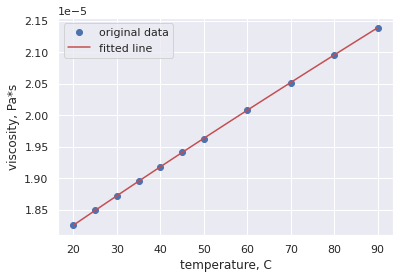

In [3]:
air = Properties() #create an instance of the properties class to define air
#now add all the properties for air
air.Mw = 0.029 #kg/mol
air.k = 0.03 #W/m/K
air.Cp = 1007 #J/kg/K
air.viscositydata_temps = [20,25,30,35,40,45,50,60,70,80,90]
air.viscositydata_vis = (np.array([1.825,1.849,1.872,1.895,1.918,1.941,1.963,2.008,2.052,2.096,2.139])*1e-5).tolist()
air.viscosityparams = np.polyfit(air.viscositydata_temps,air.viscositydata_vis,3).tolist()
air.viscosityplot().show()

#### Aluminum properties

In [4]:
aluminum = Properties()
aluminum.k = 247 #aluminum thermal conductivity, W/m/K

#### Water Properties

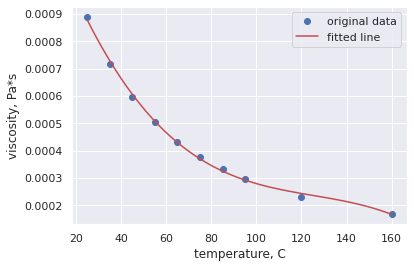

In [5]:
water = Properties() #create an instance of the properties class to define water
water.Cp = 4182 #J/kg/K
water.k = 0.598 #water thermal conductivity, W/m/K
water.rho = 997 #kg/m3, density
water.viscositydata_temps = [25,35,45,55,65,75,85,95,120,160]
water.viscositydata_vis = [8.90E-4,7.19E-4,5.96E-4,5.04E-4,4.33E-4,3.78E-4,3.33E-4,2.97E-4,2.32E-4,1.70E-4]
water.viscosityparams = np.polyfit(water.viscositydata_temps,water.viscositydata_vis,3).tolist()
water.viscosityplot().show()

#### Transmission Fluid Properties
Automatic Transmission Fluid (ATF)

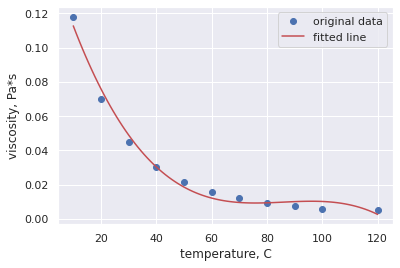

In [6]:
ATF = Properties()
ATF.Cp = 2160 #J/kg/K, estimated
ATF.k = 0.13 #W/m/K, estimated
ATF.rho = 846 #kg/m3, estimated
ATF.viscositydata_temps = [10,20,30,40,50,60,70,80,90,100,120] #https://wiki.anton-paar.com/us-en/automatic-transmission-fluid-atf/, values after 90 are there for the fit
ATF.viscositydata_vis = (np.array([118.06,70.04,44.7,30.31,21.53,15.93,12.18,9.57,7.71,6,5])*1e-3).tolist()
ATF.viscosityparams = np.polyfit(ATF.viscositydata_temps,ATF.viscositydata_vis,3).tolist()
ATF.viscosityplot().show()

### Properties of the extended surface heat exchanger


In [7]:
tubeod = 0.048 #meters
wallthickness = 0.0015 #approximation 
wallthermalconductivity = aluminum.k #W/m/K
tubeid = tubeod - 2*wallthickness # m
numberoffins = 20
tubelength = 12*0.0254 #m
baresurfacearea = tubelength*np.pi*tubeod # m^2, This is the total surface area of the tubes (outside)
internalsufacearea = np.pi*tubelength*tubeid #m^2, inside the tube
xf = 0.0137 #m,fin height
finthickness = 0.00136 #m
finsurfacearea = 2*xf*tubelength*numberoffins #m2

In [8]:
#approximate relationship between the fin parameters and the fin efficiency; see Unit Operations of Chemical Engineering 
#(McCabe, Smith, Harriott, 5th edition, page 448, Figure 15.16.)
def aita(x=0.2):
  return 1.5-1.5/(1+np.exp(-x)) + 0.25

## Approach and Initial Inputs
The approach in this writeup is to first give a **rough expected range** for the exit temperature based on some hueristics for the overall heat transfer coefficient. After that, the nitty-gritty correlations will be used to get a better estimate we'll call **the narrowed-in estimate**.

In [9]:
#define flow rate through the heat exchanger in gallons per minute (min and max)
lpmmin = 0.04; lpmmax = 0.5 #liters per minute
#define inlet temperature (min and max)
inlettempmin = 30; inlettempmax = 90 #C
#define airflow (min and max)
airflowmin = 0; airflowmax = 3 #m/s

# Range of mass flows through the heat exchanger
lpmlin = np.linspace(lpmmin, lpmmax, 100)
#Range of inlet temperatures
inletlin = np.linspace(inlettempmin,inlettempmax,3)
#Range of air flow velocities
airflowlin = np.linspace(airflowmin,airflowmax,5)

In [10]:
#define the correlation between gpm and kg/sec
def massflow(lpm=lpmmin,substance=water):
  return lpm/1000*substance.rho/60 #convert to SI units in kg/sec

### The Rough Model
This is a back-of-the-envelop estimate. There are engineering expected ranges for variables that can be effectively used to narrow in on the answer. Doing so can be very useful in understanding the problem and getting a feel for the outcome and expected results. It sometimes can be very easy to dive deeply into a problem and get lost with mistakes easily derailing your complex analysis. Doing a back-of-the-envelope estimate can help with that.

Equation to solve:      $\dot{m}\cdot C_p\cdot (T_{in}-T_{out}) = U\cdot A\cdot (T_{in} - T_{out})/ln((T_{in}-T_{air})/(T_{out}-T_{air}))$

#### Overall heat transfer coefficient Range
From the NCEES Handbook on Page 187, there's a table that is titled: Typical Overall Heat-Transfer Coefficients for Air Coolers. In that table, for a finned air cooler and water, the overall heat transfer coefficient is expected to be between 25-60 W/m2/K. Based on that and a given condition (flow rate and the intial fluid temperature and the steam temperature/pressure) the exit temperature can be found.

In [11]:
overallUhueristic = [25,60] #W/m2/K

In [12]:
#define equation to solve to obtain the exit temperature given the overall heat transfer coefficient and other parameters
def func(x,*input):
  dct = input[0]
  Tair = dct['airTemp']
  zero2rd = (dct['U']*internalsufacearea*(dct['inlettemp']-x)/np.log((dct['inlettemp']-Tair)/np.abs(x-Tair))-dct['massflow']*dct['substance'].Cp*(dct['inlettemp']-x))
  return zero2rd

#### Estimate is:

Generate curves based on the potential steam pressures and flow rates given the resultant change in temperature.

In [13]:
#Solve for each combination of water flow and air flow
#First build a dictionary that can easily be converted into a pandas dataframe (helpful for visualization and data processing)
modeleddata = {'temperature difference, C':[],'flow, lpm':[],'inlet temperature, C':[],'LMTD, C':[],'heat exchanged, W':[]} 
airTemp = 22
substanceh = water
for lpmf in lpmlin:
  massf = massflow(lpmf)
  for intemp in inletlin:
    input = {'U':overallUhueristic[1],'massflow':massf,'inlettemp':intemp,'airTemp':airTemp,'substance':substanceh}
    outtemp = fsolve(func,intemp-0.01,args=(input))[0]; tmpdiff = intemp - outtemp;
    qheat = massf*substanceh.Cp*(intemp - outtemp)
    lmtd = tmpdiff/np.log((intemp - airTemp)/(outtemp - airTemp))
    modeleddata['temperature difference, C'].append(tmpdiff); 
    modeleddata['flow, lpm'].append(lpmf); modeleddata['inlet temperature, C'].append(intemp); modeleddata['LMTD, C'].append(lmtd) 
    modeleddata['heat exchanged, W'].append(qheat)
df_maxhueristic = pd.DataFrame(modeleddata) #convert the dictionary to a dataframe    

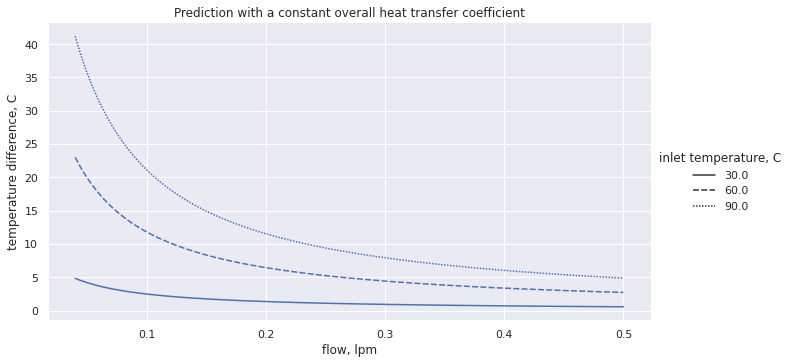

In [14]:
#now plot the temperature difference as a function of the flow (assume constant overall heat transfer coefficient)
p = sns.relplot(x='flow, lpm', y='temperature difference, C', kind="line", style='inlet temperature, C', palette='flare', data=df_maxhueristic, aspect=15/8);
#p.axes[0,0].set_ylim(-30,0);
p.set(title='Prediction with a constant overall heat transfer coefficient')
plt.show()

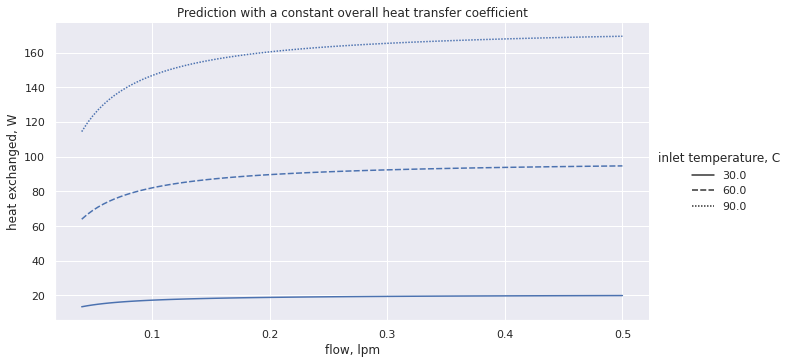

In [15]:
#now plot the heat lost (W) as a function of the flow (assume constant overall heat transfer coefficient)
p = sns.relplot(x='flow, lpm', y='heat exchanged, W', kind="line", style='inlet temperature, C', palette='flare', data=df_maxhueristic, aspect=15/8);
#p.axes[0,0].set_ylim(-30,0);
p.set(title='Prediction with a constant overall heat transfer coefficient')
plt.show()

Given a constant overall heat transfer coefficient, the above plots illustrate several points:
*  The temperature difference (inlet minus the outlet) decreases with increasing flow (expected as the residence time inside the heat exchanger is smaller with increasing flow) 
*  Increasing inlet temperatures results in a larger temperature difference as the driving force for heat exchange is larger

Why is the assumption of a constant overall heat transfer coefficient not very accurate? Or, are there conditions that you would expect it to be more accurate than others?

### The Narrowed-In Model
The heat transfer coefficients for each side of the heat exchanger can be estimated based on the flow conditions. Those calculations are completed here. We'll first estimate the tube side (interior) and then the fin side (exterior) side heat transfer coefficients from empirical correlations.

#### Tube side heat transfer coefficient
Most correlations are functions of the Reynolds and Prandlt numbers so we'll calculate those first. The correlation for laminar flow inside a circular pipe for the Nusselt number can be found on Page 150 of the NCEES Handbook and is below. 

In [35]:
def internalh(lpm=lpmmax,tubeidi=tubeid,tubelengthi=tubelength,inlettemp=inlettempmin,sub=water):
  avgtemp = inlettemp - 2
  massf = massflow(lpm,sub)
  fluidvelocity = massf/sub.rho/(np.pi/4*tubeid**2) #velocity of the fluid in m/s
  Re = sub.rho*tubeid*fluidvelocity/sub.viscosity(avgtemp) #Reynolds number, with estimate of an average temperature of 5 degrees higher than the inlet
  Pr = sub.Cp*sub.viscosity(avgtemp)/sub.k
  insideNu = ((sub.viscosity(avgtemp)/sub.viscosity(avgtemp))**0.14)*1.86*((Re*Pr)/(tubelength/tubeod))**0.33 # laminar flow, constant surface temp
  ### 
  insideNu = insideNu*1.5 #1.5 factor added to match experimental results;
  ###
  insideh = insideNu*sub.k/tubeid  #W/m2/K
  return [insideh,Re,Pr,insideNu]

In [36]:
internalh(lpm=0.43,inlettemp=44) #value at the default conditions

[220.7024592122216, 315.6253867189727, 4.479410722810078, 16.60804458954845]

#### Fin side (external) heat transfer coefficient
Quiescent or forced air contacts the exterior surface that has fins. Correlations in the NCEES Chemical Engineering handbook can be used specifically those on page 152 (free convection, external flow).

In [37]:
def externalh(airvel = airflowmax, airtemp = airTemp, exttemp = 37, sub=air):
  avetemp = (airtemp+exttemp)/2
  Re_cross = sub.idealrho(airtemp)*tubeod*airvel/sub.viscosity(airtemp)# Reynolds number - crossflow
  Re_p = sub.idealrho(airtemp)*tubelength*airvel/sub.viscosity(airtemp) #Reynolds number - parallel flow
  Pr_n = sub.Cp*sub.viscosity(exttemp)/sub.k#Prandtl number
  Gr = -9.81*sub.beta(avetemp)*(exttemp-airtemp)*(tubeod**3)/((sub.viscosity(avetemp)/sub.idealrho(avetemp))**2) #Grashoff number
  #for crossflow
  if (Re_cross > 1 and Re_cross <= 4):
    C = 0.989; nfac = 0.33
  elif (Re_cross > 4 and Re_cross <= 40):
    C = 0.911; nfac = 0.385
  elif (Re_cross > 40 and Re_cross < 4000):
    C = 0.683; nfac = 0.466
  else:
    C = 0.0266; nfac = 0.805
  ###
  C = 0.25; nfac = 0.8 #these params needed for agreement with experiment
  ###
  Nusselt_forced_c = C*(Re_cross**nfac)*Pr_n**0.33
  #for parrallel flow
  Nusselt_forced_p = 0.664*(Re_p**0.5)*Pr_n**0.33
  #for free convection
  Nusselt_free = 0.48*(Gr*Pr_n)**0.25
  ### ##
  Nusselt_free = 1.5*Nusselt_free #modified with a 1.5 factor to match the experimental results
  ####
  #coefficient
  outsideh = max(Nusselt_free,Nusselt_forced_c)*sub.k/tubeod
  outsideh_p = max(Nusselt_free*sub.k/tubeod,Nusselt_forced_p*sub.k/tubelength)
  return [outsideh, Re_cross,Re_p, Pr_n, Gr,Nusselt_free,Nusselt_forced_c,Nusselt_forced_p,outsideh_p]

In [38]:
externalh(airvel=1.3,exttemp=47) #value at the default conditions

[91.22697316972776,
 3418.396043165729,
 21706.814874102376,
 0.6544778655845159,
 228764.8810401867,
 14.16294523501261,
 145.9631570715644,
 85.05727567675453,
 8.85184077188288]

#### Overall heat transfer coefficient
The overall heat transfer coefficient is an inverse sum of the individual heat transfer coefficients including the thermal conductivity of the tube. There's also an effect from the fins to add to the external heat transfer coefficient that was calculated as a bare tube. Relations for such an approach are given in  Unit Operations of Chemical Engineering (McCabe, Smith, Harriott, 5th edition, page 448-450, Figure 15.16.)

In [39]:
def Ui(hint=internalh()[0],tubeid=tubeid,tubeod=tubeod,hext=externalh()[0]):
  xfaf = xf*np.sqrt(2*hext/(aluminum.k*finthickness))
  finEffect = internalsufacearea/(hext*(aita(xfaf)*finsurfacearea + baresurfacearea))
  kwall = 1/(wallthickness*tubeid/(aluminum.k*(tubeod-tubeid)*np.log(tubeod/tubeid)))
  Utoti = 1/(1/hint + 1/kwall + finEffect)
  return [Utoti,hint,kwall,1/finEffect] #assuming no fouling
#print(f'So the overall heat transfer coefficient, at the default conditions, is {Ui():.0f} W/m2/K which is near the range from the hueristic quoted above')

In [40]:
Ui(hint=internalh(lpm=0.43)[0],hext=externalh(airvel=1.3,exttemp=43)[0])

[119.11995044363718, 220.7024592122216, 708.4895431546706, 407.7540400205983]

#### Estimate is:
Using the above functions, the outlet temperature can be predicted given the inlet and other flow conditions.

In [41]:
#define a function to determine the outlet temperature as a function of the conditions
def predictedOutletTemp(airtemp=airTemp, lpmh=lpmmin,inlettemph=inlettempmin,airvelh=airflowmin,sub_i=water,sub_e=air,boe=False):
  hinte = internalh(lpm=lpmh,inlettemp=inlettemph,sub=sub_i)[0]
  hexte = externalh(airvel=airvelh,airtemp=airTemp,exttemp=inlettemph,sub=sub_e)[0]
  Uni = Ui(hint=hinte,hext=hexte)[0]
  U = overallUhueristic[1] if boe == True else Uni #if boe (back of the envelop value for the overall heat transfer coefficient is used)
  input = {'U':U,'massflow':massflow(lpmh),'airTemp':airtemp,'inlettemp':inlettemph,'substance':sub_i}
  outtemp = fsolve(func,inlettemph-0.01,args=(input))[0]; 
  tmpdiff = inlettemph - outtemp
  lmtd = tmpdiff/np.log((inlettemph - airtemp)/(outtemp - airtemp))
  return [outtemp,U,lmtd,hinte,hexte]

Note, anytime you're copying code or repeating the same thing, you're doing something wrong. Instead, define a function or object to complete the task once so that when you change a variable in that definition, you only need to do it once. Or in other words, make a function if you need the same line or lines of code more than once.

In [42]:
#Solve for each combination of flow and air flow
#First build a dictionary that can easily be converted into a pandas dataframe (helpful for visualization and data processing)
modelr = {'Ui':[],'temperature difference, C':[],'air flow, m/s':[],'flow, lpm':[],'inlet temperature, C':[],'LMTD, C':[],'heat exchanged, W':[]} 
for airflow in airflowlin:
  for lpmf in lpmlin:
    massf = massflow(lpmf)
    for intemp in inletlin:
      #first calculate the overall heat transfer coefficient for the condition
      solu = predictedOutletTemp(lpmh=lpmf,inlettemph=intemp,airvelh=airflow)
      outtemp = solu[0]
      qheat = massf*water.Cp*(intemp - outtemp)
      tmpdiff = intemp - outtemp;
      lmtd = tmpdiff/np.log((intemp - airTemp)/(outtemp - airTemp))
      modelr['temperature difference, C'].append(tmpdiff); modelr['air flow, m/s'].append(airflow); 
      modelr['flow, lpm'].append(lpmf); modelr['inlet temperature, C'].append(intemp); modelr['LMTD, C'].append(lmtd)
      modelr['heat exchanged, W'].append(qheat); modelr['Ui'].append(solu[1])
df = pd.DataFrame(modelr) #convert the dictionary to a dataframe  

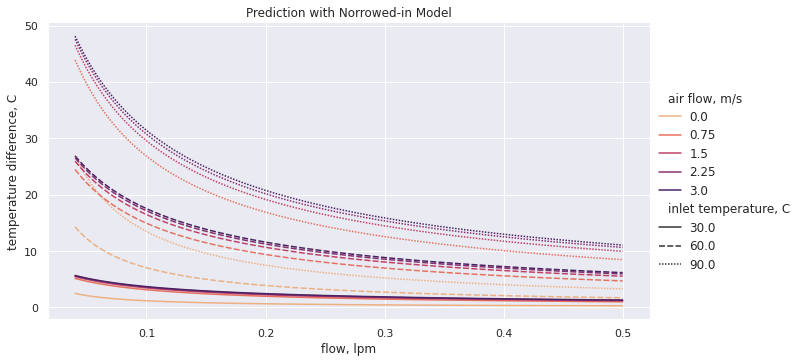

In [43]:
p = sns.relplot(x='flow, lpm',y='temperature difference, C',hue='air flow, m/s',kind="line",style='inlet temperature, C',palette='flare',data=df,aspect=15/8);
#p.axes[0,0].set_ylim(0,80); 
p.set(title='Prediction with Norrowed-in Model')
plt.show()

# Experimental Data
Data was taken from the experimental setup shown above. A video of the setup as well as the data collection scheme is on the tipice youtube channel. <br><br>
The data is posted to a github repository: https://github.com/clint-bg/demos/tree/main/ExtendedSurfaceExchanger 

In [44]:
url = 'https://raw.githubusercontent.com/clint-bg/demos/main/ExtendedSurfaceExchanger/Finned.csv' #url with data
data = pd.read_csv(url)
data.drop(data.columns[data.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True) #drop unnamed columns
data.rename(columns={'DT':'temperature difference, C','Tin':'inlet temperature, C','Air Flow, m/s':'air flow, m/s'},inplace=True)
#data = data[data['flow, lpm']>0.04]

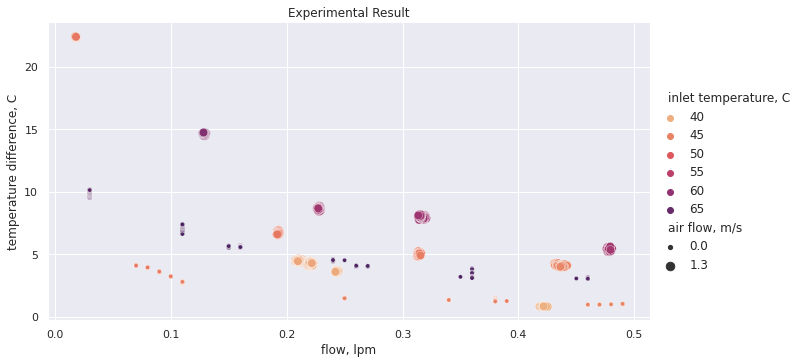

In [45]:
e = sns.relplot(x='flow, lpm',y='temperature difference, C',size='air flow, m/s',hue='inlet temperature, C',palette='flare',data=data,aspect=15/8);
#e.axes[0,0].set_ylim(0,50);
e.set(title='Experimental Result')
plt.show()

The above plot shows a similar trend as that observed with the above two models in that:
*  higher flow results in a lower temperature change
*  increased air flow yields a higher temperature difference
* higher inlet temperature yields a higher temperature difference

# Comparison between the Model Predictions (Rough and NarrowedIn) and the Experiment

In [46]:
def getall():
  #First setup the new dataframes from the existing one with the needed conditions
  modelpredict = pd.DataFrame();
  modelpredict = data.copy(); 
  boepredict = modelpredict.copy()
  data['Source'] = 'experiment'; modelpredict['Source'] = 'narrowed-in model'; boepredict['Source'] = 'rough estimate'
  #For each of the experimental conditions, calculate the model results (Rough and Narrowed-in) and then compare the residuals
  predictedarray = []; boearray = []
  for i,row in modelpredict.iterrows():
    #try:
    outsolveN = predictedOutletTemp(lpmh=modelpredict['flow, lpm'][i],inlettemph=modelpredict['inlet temperature, C'][i],airvelh=modelpredict['air flow, m/s'][i]*1)[0]
    predictedarray.append(outsolveN)
    outsolveR = predictedOutletTemp(lpmh=boepredict['flow, lpm'][i],inlettemph=boepredict['inlet temperature, C'][i],airvelh=boepredict['air flow, m/s'][i],boe=True)[0]
    boearray.append(outsolveR)
    #except RuntimeWarning:
    #  print(RuntimeWarning.args)
    #  print(f'{i}')
  modelpredict['Tout'] = predictedarray; boepredict['Tout'] = boearray
  modelpredict['temperature difference, C'] = modelpredict['inlet temperature, C'] - modelpredict['Tout']
  boepredict['temperature difference, C'] = boepredict['inlet temperature, C'] - boepredict['Tout'] 
  #modelpredict.assign(ModelPrediction = lambda modelpredict: predictedOutletTemp(gpm=modelpredict['Water Flowrate (GPM)'],inlettemp=modelpredict['Inlet Water Temperature (C)'],steampr=modelpredict['Steam Pressure (psig)'],Rfi=0))
  #concatentate the three dataframes
  dfall = pd.concat([data,modelpredict]) #,boepredict
  return dfall,modelpredict,boepredict,data

Note, although it may be easier to just create a new column in the dataframe called "Predicted Outlet Temperature" that corresponds to the other conditions in the experimental dataframe, that won't workout as well as far as ease of visualization. A better way (although more repetative) is to concatenate another table with the modeled result as done above.

In [47]:
alldat = getall()[0]

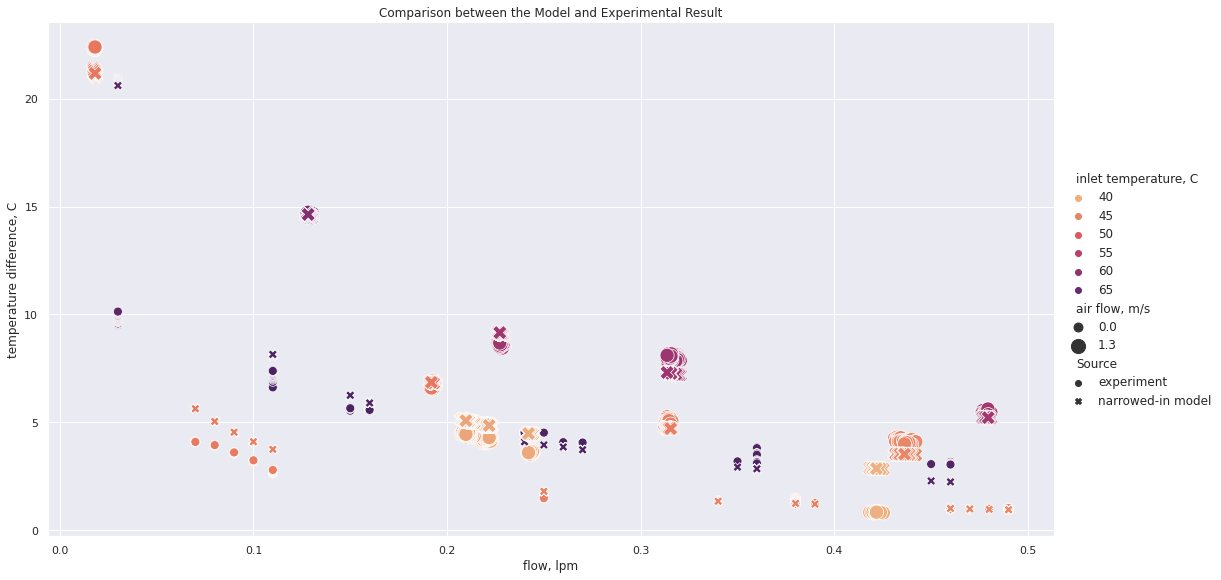

In [48]:
a = sns.relplot(data=alldat,x='flow, lpm',y='temperature difference, C',style='Source',
                hue='inlet temperature, C',size='air flow, m/s',sizes=(80, 200),palette='flare',aspect=15/8,height=8);
#a.axes[0,0].set_ylim(0,40); 
a.set(title='Comparison between the Model and Experimental Result')
plt.show()

These are the results after significantly incraesing the calculated Nusselt numbers for both the internal and external values. If that isn't done, the model is significantly off (less temperature change predicted by about half).

## Measure of Agreement:
The residuals between the experimental results and those of the model can be plotted. Additionally, an $R^2$ or coefficient of determination value can be found. There are other methods to estimate the goodness of fit (like what?).

The R^2 value for the narrowed-in model is 0.84 and 0.10 for the rough model
The sum of squared errors for the narrowed-in model is 9846.162261492675


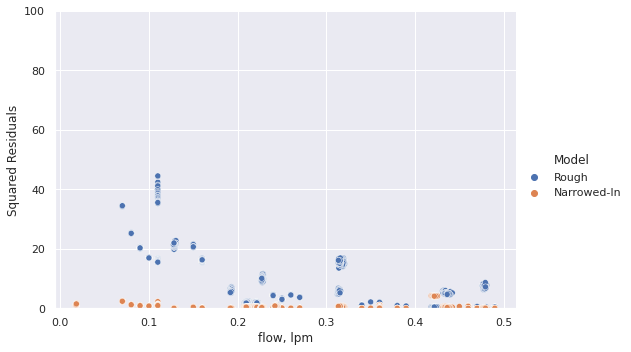

In [49]:
modelpredict = getall()[1]; boepredict = getall()[2]; data = getall()[3]
modelpredict['Squared Residuals'] = (data['temperature difference, C'] - modelpredict['temperature difference, C'])**2
boepredict['Squared Residuals'] = (data['temperature difference, C'] - boepredict['temperature difference, C'])**2
modelpredict['Model'] = 'Narrowed-In'; boepredict['Model'] = 'Rough'
aa = sns.relplot(x='flow, lpm',y='Squared Residuals',data=pd.concat([boepredict,modelpredict]),hue='Model',aspect=15/10)
seni = (modelpredict['temperature difference, C'] - data['temperature difference, C'])**2
serough = (boepredict['temperature difference, C'] - data['temperature difference, C'])**2
ssa = (data['temperature difference, C'] - data['temperature difference, C'].mean())**2
aa.axes[0,0].set_ylim(0,100); 
rsquaredni = 1-seni.sum()/ssa.sum()
rsquaredr = 1-serough.sum()/ssa.sum()
print(f'The R^2 value for the narrowed-in model is {rsquaredni:.2f} and {rsquaredr:.2f} for the rough model')
print(f'The sum of squared errors for the narrowed-in model is {seni.sum()}')

## Application to a transmission oil cooler

Suppose a transmission system holds 13 quarts of fluid and during towing it heats to a steady state tempearture of 110 degrees C, a temperature that can cause the transmission oil to breakdown resulting in damage to the transmission.

Assume that it takes about 20 minutes for the fluid to heat from 100 C to 110 C under the stressful conditions. 

What will be the steady state temperature (and how long will it take to get there) if the above extended fin heat exchanger is used with the vehicle to cool the transmission fluid? Assume a flow rate through the heat exchanger of 2 liter per minute, a 100 degree fahrenheit air temperature,  and a surrounding air velocity of 60 mph (26 m/s).

In [50]:
massfluid = 13/1056.69*ATF.rho #13 quarts to meters times the density
print(f'The mass of fluid in the transmission is approximately {massfluid:.2f} kg')

The mass of fluid in the transmission is approximately 10.41 kg


In [51]:
#set up the equation to solve and then solve it with the internal fluid specified 
def derivative(y,t,k,flow):
  inlett = y; airte = 38
  predict = predictedOutletTemp(airtemp=airte,lpmh=flow,inlettemph=inlett,airvelh=26,sub_i=ATF)
  outt = predict[0]; Uov = predict[1]; lmtd = predict[2]
  dydt = 2500 - 35*(inlett-airte) #estimate of the heat flow into and out of the fluid under stress without the additional heat exchanger
  if t>30*60*0: 
    dydt -= Uov*internalsufacearea*lmtd*k #k is a flag to turn on (1) or off (0) the effect of the heat exchanger
  return dydt/(massfluid*ATF.Cp)

#times for which to solve 
times = np.linspace(0,90*60,600) #seconds
temperatures1 = odeint(derivative,100,times,args=(0,1,))
temperatures2 = odeint(derivative,100,times,args=(1,0.5,))
temperatures3 = odeint(derivative,100,times,args=(1,2,))

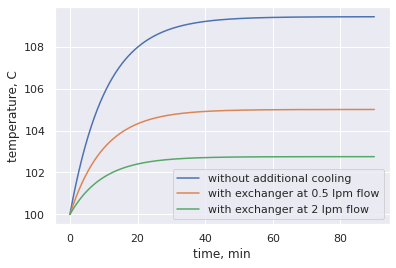

In [52]:
plt.plot(times/60, temperatures1,label='without additional cooling')
plt.plot(times/60,temperatures2,label='with exchanger at 0.5 lpm flow')
plt.plot(times/60,temperatures3,label='with exchanger at 2 lpm flow')
plt.xlabel("time, min"); plt.ylabel("temperature, C")
plt.legend()
plt.show()

In [53]:
temperatures1[-1],temperatures2[-1], temperatures3[-1]

(array([109.42646599]), array([105.00402344]), array([102.75444855]))